In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image, ImageFilter
import cv2

C:\Users\admin\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import os
os.chdir('Images')
print(os.getcwd())

C:\Users\admin\Lab_training\Week5_6\Images


tensor([[[0.8824, 0.8784, 0.8745,  ..., 0.9176, 0.8627, 0.7725],
         [0.8706, 0.8784, 0.8784,  ..., 0.9216, 0.8549, 0.7412],
         [0.8706, 0.8784, 0.8824,  ..., 0.9020, 0.8431, 0.7451],
         ...,
         [0.3216, 0.3176, 0.3608,  ..., 0.6863, 0.6863, 0.6863],
         [0.3137, 0.3176, 0.3686,  ..., 0.6941, 0.7137, 0.7176],
         [0.3176, 0.3255, 0.3765,  ..., 0.6980, 0.7176, 0.7373]],

        [[0.5412, 0.5373, 0.5333,  ..., 0.5725, 0.5059, 0.4078],
         [0.5412, 0.5373, 0.5373,  ..., 0.5882, 0.5137, 0.4000],
         [0.5412, 0.5373, 0.5412,  ..., 0.5804, 0.5216, 0.4118],
         ...,
         [0.0824, 0.0784, 0.1098,  ..., 0.2784, 0.2667, 0.2549],
         [0.0706, 0.0784, 0.1294,  ..., 0.2706, 0.2745, 0.2824],
         [0.0745, 0.0824, 0.1373,  ..., 0.2667, 0.2784, 0.2902]],

        [[0.5020, 0.4980, 0.4941,  ..., 0.4941, 0.4314, 0.3373],
         [0.4980, 0.4980, 0.4980,  ..., 0.5098, 0.4392, 0.3255],
         [0.4980, 0.4980, 0.5020,  ..., 0.4980, 0.4392, 0.

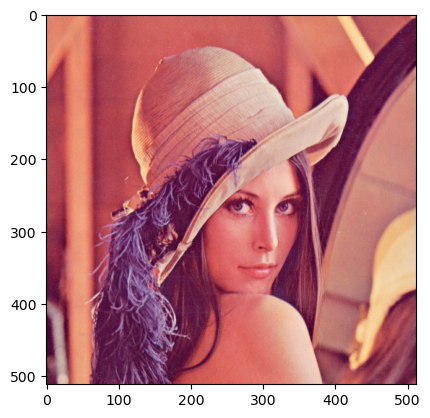

In [3]:
img_PIL = Image.open('lena.jpg')
img_ts = TF.to_tensor(img_PIL)
print(img_ts)
plt.imshow(img_ts.permute(1,2,0));

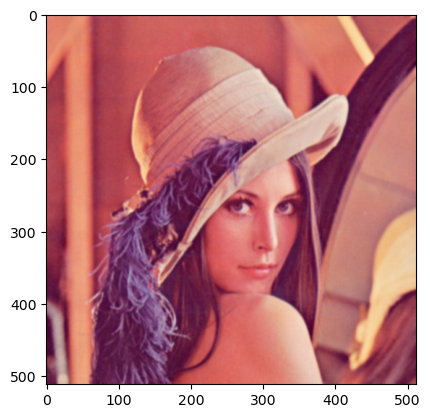

In [4]:
# Frist Step: Blur images
#img_PIL_blur = img_PIL.filter(ImageFilter.BLUR)
#img_ts_blur = TF.to_tensor(img_PIL_blur)
img_PIL_blur = img_PIL.filter(ImageFilter.GaussianBlur(radius = 1))
img_ts_blur = TF.to_tensor(img_PIL_blur)
plt.imshow(img_ts_blur.permute(1,2,0), cmap = 'gray');

In [5]:
def gradient_image(img, blur = False):
    # First Step: Blur
    if blur == True:
        img_PIL = TF.to_pil_image(img)
        img_blur = TF.to_tensor(img_PIL.filter(ImageFilter.BLUR))
        img0 = img_blur[0].unsqueeze(0).unsqueeze(0) # we can change to another channel
    else:
        img0 = img[0].unsqueeze(0).unsqueeze(0) # we can change to another channel
    # Second Step: Gradient
    Sx = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    conv1 = nn.Conv2d(1, 1, kernel_size = 3, stride = 1, padding = 1)
    conv1.weight = nn.Parameter(Sx.unsqueeze(0).unsqueeze(0))
    Gx = conv1(Variable(img0)).data.reshape(1, img0.shape[2], img0.shape[3])
    
    Sy = torch.Tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    conv2 = nn.Conv2d(1, 1, kernel_size = 3, stride = 1, padding = 1)
    conv2.weight = nn.Parameter(Sy.unsqueeze(0).unsqueeze(0))
    Gy = conv2(Variable(img0)).data.reshape(1, img0.shape[2], img0.shape[3])
    
    G_magnitude = torch.sqrt(Gx**2+Gy**2)
    G_magnitude /= G_magnitude.max() # normalize
    G_orientation = torch.arctan(Gy/Gx)
    return G_magnitude, G_orientation

tensor([[[-0.8365,  1.5232,  1.5233,  ...,  1.4796,  1.3908,  0.7296],
         [-0.0280,  0.6633,  0.6819,  ...,  0.0986,  0.0421,  0.0119],
         [-0.0408,  0.8136,  0.6533,  ...,  0.2885,  0.1969,  0.0514],
         ...,
         [-0.0346,  1.2845,  1.0857,  ...,  1.2386,  1.0633,  0.0937],
         [-0.1048, -1.2803,  1.3911,  ...,  1.3258,  1.2586,  0.0834],
         [ 0.8000,  1.5642, -1.5225,  ..., -1.5473, -1.5478, -0.7206]]])


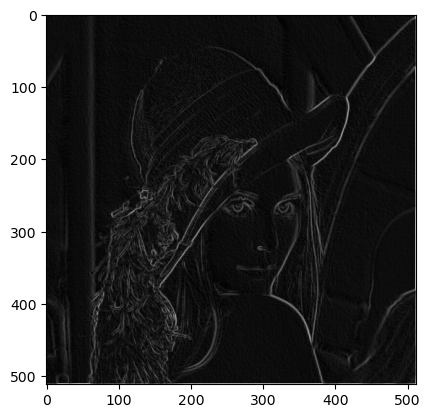

In [6]:
img_graded = gradient_image(img_ts, blur = False)
print(img_graded[1])
plt.imshow(img_graded[0].squeeze(0), cmap = 'gray');

In [7]:
def non_max_suppression(img, D):
    img_ = img.squeeze(0)*255 # easier to control, after all we'll turn it back!
    H, W = img_.shape
    angles = torch.rad2deg(D).squeeze(0)
    angles[angles<0] += 180
    res = torch.zeros_like(img_)
    
    for h in range(1, H-1):
        for v in range(1, W-1):
            q = 255
            r = 255
            # angle = 0
            if (0 <= angles[h, v] <22.5) or (157.5 <= angles[h, v] <= 180):
                q = img_[h,v+1]
                r = img_[h,v-1]
            # angle = 45
            elif (22.5 <= angles[h, v] < 67.5):
                q = img_[h+1, v-1]
                r = img_[h-1, v+1]
            # angle = 90
            elif (67.5 <= angles[h, v] < 112.5):
                q = img_[h+1, v]
                r = img_[h-1, v]
            #angle 135
            elif (112.5 <= angles[h, v] < 157.5):
                q = img_[h-1, v-1]
                r = img_[h+1, v+1]
            
            if (img_[h, v] >= q) and (img_[h, v] >= r):
                res[h, v] = img_[h, v]
    return (res/255).unsqueeze(0)

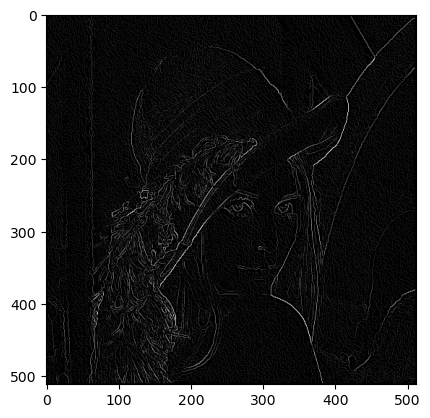

In [8]:
nms = non_max_suppression(img_graded[0], img_graded[1])
plt.imshow(nms.squeeze(0), cmap = 'gray');

In [9]:
def double_threshold(img, low = 10, high = 30):
    weak = 50
    strong = 255
    img_ = img.squeeze()*255 # esier to control
    res = torch.zeros_like(img_)
    weak_x, weak_y = np.where((img_ > low)&(img_<high))
    strong_x, strong_y = np.where((img_ >= high))
    res[weak_x, weak_y] = weak
    res[strong_x, strong_y] = strong
    return (res/res.max()).unsqueeze(0)

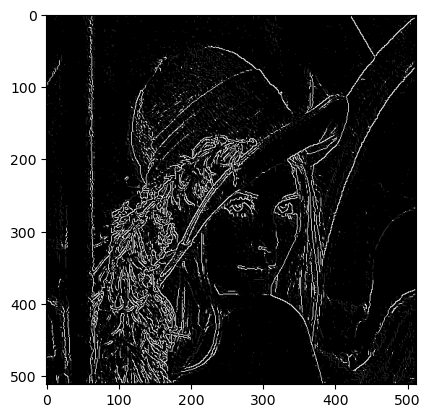

In [10]:
dt = double_threshold(nms, low = 20, high = 30)
plt.imshow(dt.squeeze(), cmap = 'gray');

In [11]:
def hysteresis(img, weak, strong = 255):
    img_ = img.squeeze()*255
    H, W = img_.shape
    for h in range(1,H-1):
        for v in range(1,W-1):
            if (img_[h, v] == weak):
                if ((img_[h+1, v-1] == strong) or (img_[h+1, v] == strong) or (img_[h+1, v+1] == strong)
                    or (img_[h, v-1] == strong) or (img_[h, v+1] == strong)
                    or (img_[h-1, v-1] == strong) or (img_[h-1, v] == strong) or (img_[h-1, v+1] == strong)):
                    img_[h, v] = strong
                else:
                    img_[h, v] = 0
    return (img_/255).unsqueeze(0)

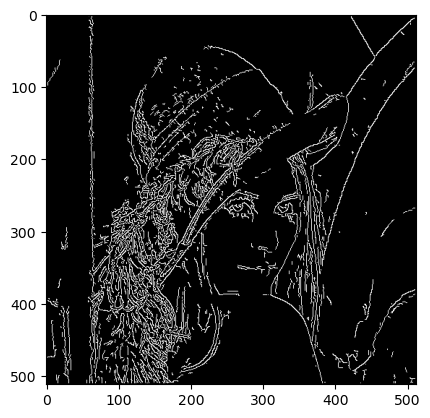

In [12]:
h = hysteresis(dt, weak = 50.)
plt.imshow(h.squeeze(0), cmap = 'gray');

In [13]:
def Canny(img, blur = False, low = 10, high = 30):
    img_graded = gradient_image(img, blur = blur)
    nms = non_max_suppression(img_graded[0], img_graded[1])
    dt = double_threshold(nms, low = low, high = high)
    h = hysteresis(dt, weak = 50.)
    return h

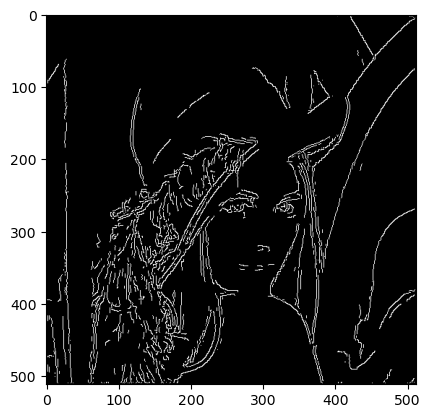

In [14]:
canny = Canny(img_ts, blur = True, low = 15, high = 20)
plt.imshow(canny.squeeze(0), cmap = 'gray');